In [1]:
%matplotlib inline


# TORCH
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torchvision
from sklearn.metrics import accuracy_score



In [19]:

def live_plot(loss, train_acc, valid_acc=None, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.plot(loss, label='Training Loss', color='red')
    ax1.legend(loc='lower left')
    ax1.set_ylabel('Cross Entropy Loss')
    ax2 = ax1.twinx()
    ax2.plot(train_acc, label='Training Accuracy', color='green')
    if valid_acc is not None:
        ax2.plot(valid_acc, label='Validation Accuracy', color='blue')
    ax2.legend(loc='lower right')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_xlabel('Epoch')
    plt.title(title)
    plt.show()

In [2]:
batch_size = 20
epochs = 15
IMG_HEIGHT = 255
IMG_WIDTH = 255

In [3]:
def load_train_dataset():
    data_path = './data/'
    train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=torchvision.transforms.ToTensor()
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return train_loader, train_dataset.class_to_idx

In [12]:
def load_data_np(batches=100):
    # Load a subsample of training data and all of the validation data into a flattened NumPy format.
    train_data_np = []
    train_labels = []
    batch_limit = batches
    for index, (data, label) in enumerate(train_dataset):
        for i in range(data.shape[0]):
            train_data_np.append(data[i].detach().numpy().flatten())
            train_labels.append(int(label[i].detach().numpy()))
        if index >= batch_limit - 1:
            break
    train_data_np = np.vstack(train_data_np)
    train_labels = np.array(train_labels)

#     valid_data_np = []
#     valid_labels = []
#     for data, label in valid_dataset:
#         if data.shape[0] < 3:
#             data = torch.cat([data[0], data[0], data[0]], dim=0)  # Convert grayscale images into RGB format
#         valid_data_np.append(data.detach().numpy().flatten())
#         valid_labels.append(int(label))
#     valid_data_np = np.vstack(valid_data_np)
#     valid_labels = np.array(valid_labels)
    return train_data_np, train_labels

In [13]:
train_dataset, class_to_idx = load_train_dataset()

In [15]:
# Load data into 'flattened' NumPy arrays
train_data_np, train_labels = load_data_np(batches=20)
print(f"Training Data Shape: {train_data_np.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
# print(f"Validation Data Shape: {valid_data_np.shape}")
# print(f"Validation Labels Shape: {valid_labels.shape}")

Training Data Shape: (200, 195075)
Training Labels Shape: (200,)


In [6]:
class LinearModel(torch.nn.Module):
    
    def __init__(self, input_size, num_classes):
        
        super().__init__()
        
        # Neural Network Architecture
        self.dense1 = torch.nn.Linear(in_features=num_features, out_features=num_classes)
        self.activation = torch.nn.LogSigmoid()
    
    def forward(self, X):
        X = self.dense1(X)
        X = self.activation(X)
        return X

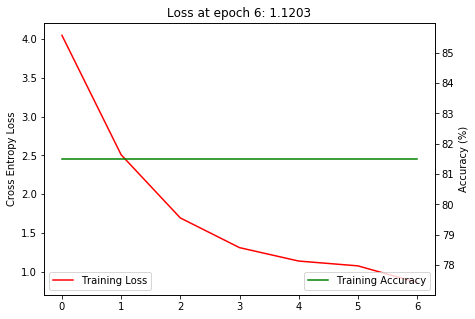

KeyboardInterrupt: 

In [20]:
batch_limit = 20

# Load data into 'flattened' NumPy arrays
# train_data_np, train_labels, valid_data_np, valid_labels = load_data_np(batches=batch_limit)

num_features = 255*255*3
num_classes = 200
max_iter = 100
model = LinearModel(num_features, num_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
criterion = torch.nn.CrossEntropyLoss()

loss_list = []
accuracy_list = []
valid_list = []

for i in range(max_iter):
    epoch_loss = 0
    for index, (data, label) in enumerate(train_dataset):
        data = data.view(batch_size, -1)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(input=y_pred, target=label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"Batch loss ({index+1}/{batch_limit}): {loss.item()}", end='\r')
        if index >= batch_limit -1:
            break
    with torch.no_grad():
        loss_list.append(epoch_loss/batch_limit)
        y_pred = model.forward(torch.Tensor(train_data_np.reshape(-1, num_features)))
        y_pred = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy_list.append(accuracy_score(y_true=train_labels, y_pred=y_pred)*100)
#         y_pred_val = model.forward(torch.Tensor(valid_data_np.reshape(-1, num_features)))
#         y_pred_val = torch.argmax(y_pred_val, dim=1).detach().numpy()
#         valid_list.append(accuracy_score(y_true=valid_labels, y_pred=y_pred_val)*100)
        live_plot(np.array(loss_list), 
                  np.array(accuracy_list), 
#                   valid_list, 
                  title=f"Loss at epoch {i}: {loss.item():.4f}") 